# Machine learning from scratch - Neural Network

This Jupyter notebook implements a neural network from scratch using `numpy`.

In [1]:
import numpy as np
from numpy.random import random as rnd
from sklearn.datasets import load_digits
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sn.set(font_scale=1.4)

In [2]:
# ------------------------------
# Define different layer types for use in an NN
# ------------------------------

class Layer(object):
    def init(self):
        pass
    
    # returns: output from this layer.
    def forward(self, x):
        pass
    
    # grad_after: the gradient of the loss w.r.t to the output of this layer
    # should return grad_prev: the gradient of the loss w.r.t the previous layer
    # note: according to the chain rule grad_prev = grad_this * grad_after
    # (this is also the place to calculate the gradients w.r.t different params)
    def backward(self, grad_after):
        pass
    
    # using gradient descent, update params based on gradients that
    # were calculated in backward()
    # alpha = learning rate, beta = momentum
    def update(self, alpha, beta):
        pass
    
class Linear(Layer):
    def __init__(self, n_input, n_output):
        self.w = rnd((n_output, n_input)) * 0.1
        self.b = rnd((n_output, 1)) * 0.1
        
        # "velocities" used for momentum!
        self.vw = 0.0
        self.vb = 0.0
    
    def forward(self, x):
        # x: (N_samples, n_input), w: (n_input, n_output)
        self.input = x
        return self.w @ x + self.b
    
    # calculate the gradient of this layer w.r.t. to its weights
    def backward(self, grad_after):
        m = self.input.shape[1]
        self.grad_w = (grad_after @ self.input.T) / m
        self.grad_b = np.mean(grad_after, axis=1, keepdims=True)
        return self.w.T @ grad_after
    
    def update(self, alpha, beta):
        self.vw = beta * self.vw + (1-beta) * self.grad_w
        self.vb = beta * self.vb + (1-beta) * self.grad_b
        self.w -= alpha * self.vw
        self.b -= alpha * self.vb
    
    
class Relu(Layer):
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_after):
        return (self.input > 0) * grad_after

class Sigmoid(Layer):
    def forward(self, x):
        self.input = x
        return 1 / (1 + np.exp(-x))
    
    def backward(self, grad_after):
        e = np.exp(-self.input)
        return grad_after * (e / (1 + e)**2)

def cross_entropy_loss(y_hat, y_oh):
    return -np.mean(y_oh * np.log(y_hat) + (1 - y_oh) * np.log(1 - y_hat))

# the gradient of the loss function, w.r.t. to y_hat!
# both inputs are one-hot/probability matrices size (n_classes, n_samples)
def cross_entropy_grad(y_hat, y_oh):
    return -(y_oh / y_hat - (1-y_oh) / (1-y_hat))

def accuracy(y_hat, y):
    y_pred = np.argmax(y_hat, axis=0)
    return np.mean(y_pred == y)

In [3]:
## -------------------
## -- helper methods to construct and train the network!
## -- the network is just a list of layers!
## -------------------

def build_network(sizes):
    network = []
    for i in range(len(sizes) - 2):
        network.append(Linear(sizes[i], sizes[i+1]))
        network.append(Relu())
    network.append(Linear(sizes[-2], sizes[-1]))
    network.append(Sigmoid())
    return network

def full_forward(network, x):
    # network requires format (n_features, n_samples)
    # --> that is, we want the columns to be feature vectors!
    # (default x is in shape (n_samples, n_features))
    x = x.T
    
    for l in network:
        x = l.forward(x)
    return x

# x_train format: (n_samples, n_features)
# y_train format: (n_samples,) <-- list of class indices
def train(x_train, y_train, network, alpha, beta = 0.0, early_stop_acc=0.98):
    # for training, we want y to be a one-hot vector of the shape
    # (n_classes, n_samples) <-- input into this method is (n_samples,)
    y_train = np.eye(n_classes)[y_train].T
    # record 20 latest accuracies for early stopping...
    accuracies = [0]*20
    for epoch in range(1, 20000 + 1):
        y_hat = full_forward(network, x_train)
        
        acc = accuracy(y_hat, y)
        accuracies[epoch % 20] = acc
        
        if epoch == 1 or epoch % 1000 == 0:
            loss = cross_entropy_loss(y_hat, y_train)
            print("Round %d, accuracy: %.2f, loss: %4.4f" % (epoch, acc, loss))
            if np.min(accuracies) > early_stop_acc:
                break

        # note: we don't actually need the loss itself.
        # only its gradient!
        da = cross_entropy_grad(y_hat, y_train)
        for l in network[::-1]:
            da = l.backward(da)
            l.update(alpha, beta)

Round 1, accuracy: 0.10, loss: 2.3175
Round 1000, accuracy: 0.96, loss: 0.0340
Round 2000, accuracy: 0.99, loss: 0.0131
Round 3000, accuracy: 1.00, loss: 0.0066


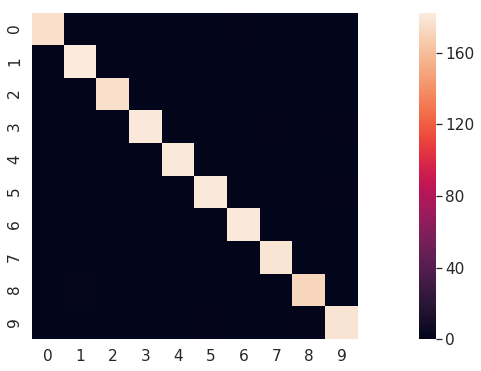

In [7]:
np.random.seed(0)
X, y = load_digits(return_X_y=True)
X = X / np.max(X) # crude scaling for x

n_classes = np.max(y) + 1
_, n_features = X.shape

sizes = [n_features, 30, 30, n_classes] # dense network sizes
network = build_network(sizes)

alpha = 0.05 # learning rate
beta = 0.9 # momentum
train(X, y, network, alpha, beta, 0.99)

y_pred_p = full_forward(network, X)

# plot heat map of results
y_pred = np.argmax(y_pred_p, axis=0)
matr = confusion_matrix(y, y_pred).astype(np.int)

def plot_heatmap(matr):
    plt.figure(figsize=(22, 6))
    sn.heatmap(matr, square=True)

plot_heatmap(matr)